# House Price Prediction

## Introduction
In this project, we will look at houses prices in Ames and create a model to predict house prices. Couple things we will do in the project:
- Feature Engineering
- Feature Selection
- Model Building

In [212]:
#Import
import pandas as pd
import numpy as np

#Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#ML
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

#Hide Warnings
import warnings
warnings.filterwarnings('ignore')

In [216]:
#Import CSV file
house = pd.read_csv('AmesHousing.tsv', delimiter="\t")
house_copy = house.copy()

## Feature Engineering

Numerical columns: For columns that have less than 5% missing values, we can replace NULLs with the mode from each column.

In [229]:
#Which columns have less than 5% missing values? These are fixable
five_null = house[null_house_percent[(null_house_percent < 0.05) & (null_house_percent > 0)].index]
numerical_null = five_null.select_dtypes(include=["integer","float"])
print((numerical_null.isnull().sum()).sort_values())

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64


In [230]:
#Check for null values that are numerical
replacement_dict = house[numerical_null.columns].mode().to_dict(orient='records')[0]
replacement_dict

{'Mas Vnr Area': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0}

In [231]:
house = house.fillna(replacement_dict)

Some columns can be captured better

In [232]:
years_sold = house['Yr Sold'] - house['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [233]:
years_since_remod = house['Yr Sold'] - house['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [234]:
#We want to drop the values that are less than 0
house["Years_Before_Sale"] = years_sold
house["Years_Since_Remod"] = years_since_remod

house = house.drop([1702, 2180, 2181], axis=0)

#We dont need these columns anymore
house = house.drop(['Year Built', 'Year Remod/Add'], axis=1)

There are some values that are not suitable for ML and that leak data for final sale

In [235]:
#Columns that aren't used for ML
house = house.drop(['PID', 'Order'], axis=1)

#Columns that leak data for final sale
house = house.drop(['Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold'], axis=1)

## Feature Selection

In [236]:
numerical_df = transform_df.select_dtypes(["integer", "float"])
numerical_df.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years_Before_Sale,Years_Since_Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,...,210,62,0,0,0,0,0,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,...,140,0,0,0,120,0,0,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,...,393,36,0,0,0,0,12500,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,...,0,0,0,0,0,0,0,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,...,212,34,0,0,0,0,0,189900,13,12


In [237]:
abs_corr = numerical_df.corr()['SalePrice'].abs().sort_values()
print(abs_corr)

BsmtFin SF 2         0.006127
Misc Val             0.019273
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years_Since_Remod    0.534985
Full Bath            0.546118
Years_Before_Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: Sale

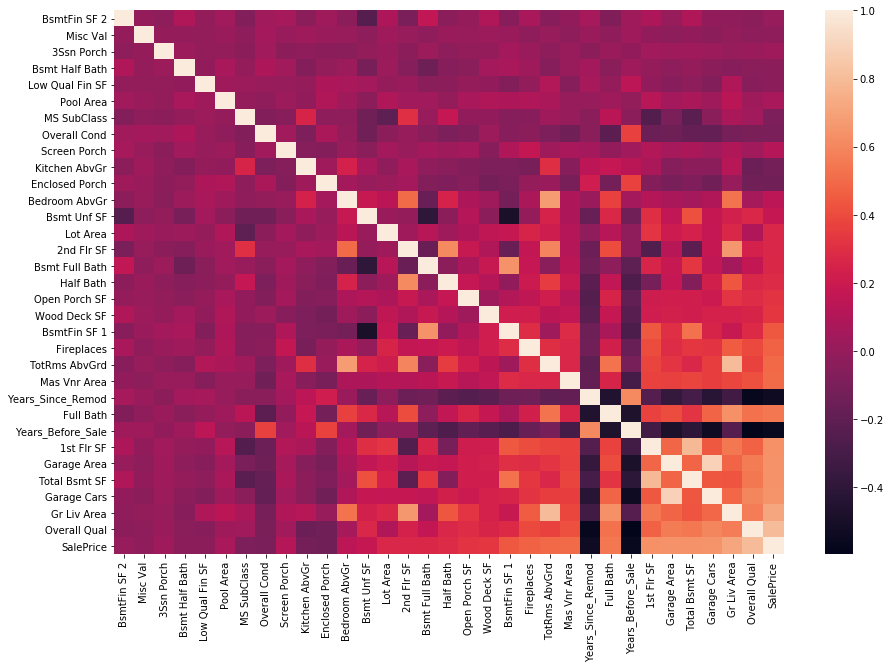

In [238]:
corrmat = numerical_df[abs_corr.index].corr()
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(corrmat)

Let's select the features that have a correlation greater than 0.4

In [239]:
abs_corr[abs_corr > 0.4]

BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years_Since_Remod    0.534985
Full Bath            0.546118
Years_Before_Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: SalePrice, dtype: float64

In [240]:
#Drop columns with a correlation lesser than 0.4
transform_df = transform_df.drop(abs_corr[abs_corr < 0.4].index, axis=1)

Next we will convert nominal features into the categorical data type

In [241]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

If a column has too many unique values, we are going to drop these since creating dummy code we will have to add hundreds of columns into the dataframe.

In [242]:
transform_cat_cols = []
for cols in nominal_features:
    if cols in transform_df.columns:
        transform_cat_cols.append(cols)

#Find the number of unique values
uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()

#Drop non-unique columns. We will consider 10 as the arbitrary threshold
drop_non_unique_cols = uniqueness_counts[uniqueness_counts > 10].index
transform_df = transform_df.drop(drop_non_unique_cols, axis=1)

In [243]:
#Change text columns to categorical
text_cols = transform_df.select_dtypes(include=["object"])
for col in text_cols:
    transform_df[col] = transform_df[col].astype("category")

#Create dummy columns and add them back to the dataframe
transform_df = pd.concat(
    [transform_df,
    pd.get_dummies(transform_df.select_dtypes(include=["category"]))
    ], axis=1).drop(text_cols,axis=1)

In [262]:
def transform_features(df):
    #Drop any columns with null value > 5%
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    #Update Text
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    #Update numerical
    null_house_percent = df.select_dtypes(include=["integer", "float"]).isnull().sum()
    five_null = df[null_house_percent[(null_house_percent < len(df)/20) & (null_house_percent > 0)].index]
    replacement_dict = df[numerical_null.columns].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_dict)
    
    #Update other columns
    years_sold = df['Yr Sold'] - df['Year Built']
    years_sold[years_sold < 0]
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    years_since_remod[years_since_remod < 0]
    df["Years_Before_Sale"] = years_sold
    df["Years_Since_Remod"] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)
    df = df.drop(['Year Built', 'Year Remod/Add'], axis=1)
    
    
    df = df.drop(['PID', 'Order'], axis=1)
    df = df.drop(['Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold'], axis=1)
    return df

def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(["integer", "float"])
    numerical_df.head()
    abs_corr = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr[abs_corr < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    transform_cat_cols = []
    for cols in nominal_features:
        if cols in df.columns:
            transform_cat_cols.append(cols)

    #Find the number of unique values
    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()

    #Drop non-unique columns. We will consider 10 as the arbitrary threshold
    drop_non_unique_cols = uniqueness_counts[uniqueness_counts > uniq_threshold].index
    transform_df = df.drop(drop_non_unique_cols, axis=1)
    
    #Change text columns to categorical
    text_cols = transform_df.select_dtypes(include=["object"])
    for col in text_cols:
        transform_df[col] = transform_df[col].astype("category")

    #Create dummy columns and add them back to the dataframe
    transform_df = pd.concat(
        [transform_df,
        pd.get_dummies(transform_df.select_dtypes(include=["category"]))
        ], axis=1).drop(text_cols,axis=1)
    
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop('SalePrice')
    lr = LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train['SalePrice'])
        predictions = lr.predict(test[features])
        rmse = mean_squared_error(predictions, test['SalePrice'])**(1/2)
        
        return rmse
    elif k == 1:
        shuffled_df = df.sample(frac = 1,)
        fold_one = df[:1460]
        fold_two = df[1460:]
        
        lr.fit(fold_one[features], fold_one['SalePrice'])
        prediction = lr.predict(fold_two[features])
        rmse = mean_squared_error(prediction, fold_two['SalePrice'])
        
        lr.fit(fold_two[features], fold_two['SalePrice'])
        prediction_two = lr.predict(fold_one[features])
        rmse_two = mean_squared_error(prediction_two, fold_one['SalePrice'])
        
        avg_rmse = np.mean([rmse, rmse_two])
        return avg_rmse
    else:
        kf = KFold(k, shuffle=True)
        rmse_values = []
        for train_index, test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train['SalePrice'])
            predictions = lr.predict(test[features])
            rmse = mean_squared_error(predictions, test['SalePrice'])**(1/2)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

In [265]:
transform_df = transform_features(house_copy)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse

[39088.6977054144, 29675.916309015254, 35742.691462915296, 29861.84055447129]


33592.286507954064